# NLP - Author Attribution

## Identifying authors through excerpts

------

A notebook using Python alongside sklearn and NLTK to develop an NLP classifier. Given a collection of data on six Portuguese authors, we first analyze the data and take some general decisions on how to tackle the task. We make use of NLTK features to clean the data alongside some BASH scripts. The models are built and trained with sklearn.

Final predictions based on best model:

1000 word excerpts:

- testData/1000words/text1_clean.txt: joseSaramago
- testData/1000words/text2_clean.txt: almadaNegreiros
- testData/1000words/text3_clean.txt: luisaMarquesSilva
- testData/1000words/text4_clean.txt: ecaDeQueiros
- testData/1000words/text5_clean.txt: camiloCasteloBranco
- testData/1000words/text6_clean.txt: joseRodriguesSantos

500 word excerpts:

- testData/500words/text1_clean.txt: joseSaramago
- testData/500words/text2_clean.txt: almadaNegreiros
- testData/500words/text3_clean.txt: luisaMarquesSilva
- testData/500words/text4_clean.txt: ecaDeQueiros
- testData/500words/text5_clean.txt: camiloCasteloBranco
- testData/5000words/text6_clean.txt: joseRodriguesSantos

------
Authors: 
- Davide Montali M20190201
- Francisco Cruz M20190637
- Umberto Tammaro M20190806

Course: Text Mining -- Nova IMS

------

# Requirements and Imports

Please ensure you have the dependencies below installed and make sure to download the required NLTK data.

In [25]:
import pandas as pd
import numpy as np
import nltk
import glob
import re
import shutil
from pathlib import Path

from itertools import count
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [2]:
# Please make sure you have the following parts downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/d4ve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Normalising

We use a quick bash script to normalize the data. We first of all translate the data into ascii standard, to remove the various portuguese accents. Then we take the complement of the following set: 'A-Za-z0-9-,.!?"' - we decided to keep the punctuation given the varying use of punctuation by the different authors. We also lowercase the documents and merge them into a corpus document.

In [3]:
%%bash
unzip -q project-20200323.zip
rm -rf trainData testData cleanData
mkdir trainData testData cleanData
mv project/Corpora/train/* trainData/
mv project/Corpora/test/* testData/
rm -rf project/

In [4]:
%%bash
rm -rf trainData/*/*clean.txt
rm -rf trainData/*/corpus.txt
for dir in trainData/*/; do
    for book in $dir*.txt; do
        iconv -f utf8 -t ascii//TRANSLIT "$book" | tr -sc 'A-Za-z0-9-,.!?;:' ' ' | tr A-Z a-z  >> "${dir}corpus.txt"
    done
done

We also apply the same script to the data to be identified, although here for obvious reasons we don't concatenate the files into a corpus document.

In [5]:
%%bash
rm -rf testData/*/*clean.txt
for dir in testData/*/; do
    for book in $dir*.txt; do
        iconv -f utf8 -t ascii//TRANSLIT "$book" | tr -sc 'A-Za-z0-9-,.!?"' ' ' | tr A-Z a-z  > "${book%.*}"_clean.txt
    done
done

We define our functions used throughout the notebook as well as some variables we use. We also load the NLTK portuguese stemmer and stopwords.

In [6]:
def map_author(path):
    """Determine the author of a book through its file path."""
    for key, author in authors.items():
        if author.lower() in path.lower():
            return author
        
def clean_doc(doc, stopwords=True):
    doc = stem_doc(doc)
    if stopwords == True:
        doc = stop_doc(doc)
    return doc

def stem_doc(doc):
    """Takes a document, splits it up and stemms each word - then
    remerges the document together and returns it."""
    doc_split = doc.split()
    stem = [stemmer.stem(str(i)) for i in doc_split]
    doc = ' '.join(stem)
    return doc

def stop_doc(doc):
    """Takes a document and removes all stopwords from it"""
    doc_split = doc.split()
    temp = [i for i in doc_split if i not in stopwords]
    doc = ' '.join(temp)
    return doc

def clean_new_data(doc):
    doc = re.split(r'(\W+)', doc)
    doc = ' '.join(doc)
    doc = clean_doc(doc)
    return doc

unknown = glob.glob('testData/*/*clean.txt')
unknown.sort()

def predict_unknown(model):
    for doc in unknown:
        with open(doc) as file:
            file = [clean_new_data(file.read())]
            y = int(model.predict(file))
            print(f"{doc} --> {book_data.target_names[y]}")
            
def tester(model):
    # Reload files - in case we're working with different data splits
    book_data = load_files('cleanData/', encoding="UTF-8")
    X_train, X_test, y_train, y_test = train_test_split(book_data.data, book_data.target)
    
    model.fit(X_train, y_train)
    
    predicted = model.predict(X_test)
    print(np.mean(predicted == y_test))
    
    predict_unknown(model)

authors = {
            1: "almadaNegreiros",
            2: "ecaDeQueiros",
            3: "joseSaramago",
            4: "camiloCasteloBranco",
            5: "joseRodriguesSantos",
            6: "luisaMarquesSilva"}

# NLTK Tools
stopwords = list(nltk.corpus.stopwords.words('portuguese'))
stemmer = nltk.stem.RSLPStemmer()

## Balancing

Given the large imbalance in terms of words per author we have, we decided to split the corpus of each author into a number of smaller documents. Below we split into 500 word documents - the same count as the shortest excerpts we are looking to predict.

We also decided to undersample our data - this is further motivated by the vast imbalance ratio between the different auhtors. We explored oversampling as well - but given that we would generate new data for our minority class on the already scarce data we have, we decided undersampling was a more sensible route.

We store our data in a separate folder, with documents within a subfolder named after the authors (our target variable) - using this format we can easily read our data into sklearn.

In [7]:
# Training data paths
corpora = glob.glob('trainData/*/corpus.txt')

# Create a function to split the data into smaller files, and save them to file
# use the sklearn dataset format - so later files can be worked with easily.

def trucate(paths, w_path='cleanData/', words=500, max_splits=300):
    """Truncate function takes a list of corpora paths, and splits them
    based on the parameters set. The default is to write the files to a new
    folder with the authors as subdirectories and splitting documents into 500
    word docs, with a maximum of 300 splits per author. -1 splits makes all splits
    possible, without undersampling""" 
    
    # Make sure previous splits are deleted, to avoid errors
    # regarding split numbers or max words
    try:
        shutil.rmtree(w_path)
    except:
        print('Creating new folder for split.\n')
        
    for path in paths:
        print(f'Segmenting {map_author(path)}:')
        
        corpus = None
        
        with open(path) as file:
            corpus = file.read()
        
        corpus = clean_doc(corpus)
        corpus = re.split(r'(\W+)', corpus)
        print('Done.\n')
        
        if max_splits == -1:
            splits = len(corpus) // words
            # Make sure we don't loose data due to floor division.
            if len(corpus) % words > 0: splits += 1
        elif len(corpus) // words < max_splits:
            splits = len(corpus) // words
            # Make sure we don't loose data due to floor division.
            if len(corpus) % words > 0: splits += 1
        else:
            splits = max_splits
        if len(corpus) % words > 0: splits += 1
        
        # Set filename with itertools
        filename = ("/corpus_part_%03i.txt" % i for i in count(1))
        
        # Check if directories exist, and except errors
        # in case they do, otherwise create them.
        path_auth = w_path + map_author(path)
        Path(path_auth).mkdir(parents=True, exist_ok=True)
        
        cut = words
        for i in range(splits - 1):
            seg = ' '.join(corpus[(words*i):cut])
            seg = re.sub(' +', ' ', seg)
            with open(path_auth + next(filename), "w") as file:
                file.write(seg)
            cut += words
            
trucate(corpora, words=500, max_splits=100)

Segmenting almadaNegreiros:
Done.

Segmenting camiloCasteloBranco:
Done.

Segmenting joseRodriguesSantos:
Done.

Segmenting luisaMarquesSilva:
Done.

Segmenting joseSaramago:
Done.

Segmenting ecaDeQueiros:
Done.



## Load Data
With our cleaned and balanced data, we load the data into sklearn with the load_files function.

In [8]:
# Using sklearn load_data it will deduce the target variables
# from the folder names - in our case the authors
book_data = load_files('cleanData/', encoding="UTF-8")

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(book_data.data, book_data.target)

## KNN Bayes


In [9]:
KNN_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1))),
    ('clf', KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='brute', leaf_size=30, p=2,
                                metric='cosine', metric_params=None, n_jobs=1)),
])

KNN_clf.fit(X_train, y_train)

predicted = KNN_clf.predict(X_test)
np.mean(predicted == y_test)

0.9733333333333334

In [10]:
predict_unknown(KNN_clf)

testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> almadaNegreiros
testData/1000Palavras/text3_clean.txt --> luisaMarquesSilva
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> almadaNegreiros
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> luisaMarquesSilva
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> camiloCasteloBranco
testData/500Palavras/text6_clean.txt --> almadaNegreiros


## Naive Bayes

We split our data and fit the NB model with an sklearn pipeline.

In [11]:
# Use sklearn pipeline to create our NB classifier
NB_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1),
                             token_pattern=r"(?u)\b\w\w+\b|!+|\?|\.+|,|-+|:|;")),
    ('clf', MultinomialNB(alpha=0.001)), # We add smoothing to our NB 
])

NB_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b|!+|\\?|\\.+|,|-+|:|;',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))],
         verbose=False)

To validate our score, we use sklearn crossvalidation on the training data. Thereafter, we use the model to predict the values of our aforemention excluded test set.

In [12]:
scores = cross_val_score(NB_clf, X_train, y_train, cv=10)
scores

array([1.        , 1.        , 0.97777778, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [13]:
predicted = NB_clf.predict(X_test)
np.mean(predicted == y_test)

1.0

## NB Prediction

In [14]:
tester(NB_clf)

1.0
testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> almadaNegreiros
testData/1000Palavras/text3_clean.txt --> luisaMarquesSilva
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> joseRodriguesSantos
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> luisaMarquesSilva
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> camiloCasteloBranco
testData/500Palavras/text6_clean.txt --> joseRodriguesSantos


In [15]:
print(metrics.classification_report(y_test, predicted, target_names=book_data.target_names))

                     precision    recall  f1-score   support

    almadaNegreiros       1.00      1.00      1.00        26
camiloCasteloBranco       1.00      1.00      1.00        28
       ecaDeQueiros       1.00      1.00      1.00        20
joseRodriguesSantos       1.00      1.00      1.00        30
       joseSaramago       1.00      1.00      1.00        19
  luisaMarquesSilva       1.00      1.00      1.00        27

           accuracy                           1.00       150
          macro avg       1.00      1.00      1.00       150
       weighted avg       1.00      1.00      1.00       150



In [16]:
metrics.confusion_matrix(y_test, predicted)

array([[26,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0],
       [ 0,  0,  0,  0, 19,  0],
       [ 0,  0,  0,  0,  0, 27]])

## SVM 

In [17]:
SVM_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(alpha=0.01)),
])

SVM_clf.fit(X_train, y_train)

predicted = SVM_clf.predict(X_test)
np.mean(predicted == y_test)

0.9866666666666667

In [18]:
print(metrics.classification_report(y_test, predicted, target_names=book_data.target_names))

                     precision    recall  f1-score   support

    almadaNegreiros       1.00      1.00      1.00        26
camiloCasteloBranco       1.00      1.00      1.00        28
       ecaDeQueiros       0.95      1.00      0.98        20
joseRodriguesSantos       1.00      0.97      0.98        30
       joseSaramago       0.95      1.00      0.97        19
  luisaMarquesSilva       1.00      0.96      0.98        27

           accuracy                           0.99       150
          macro avg       0.98      0.99      0.99       150
       weighted avg       0.99      0.99      0.99       150



In [19]:
metrics.confusion_matrix(y_test, predicted)

array([[26,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0],
       [ 0,  0,  1, 29,  0,  0],
       [ 0,  0,  0,  0, 19,  0],
       [ 0,  0,  0,  0,  1, 26]])

In [20]:
predict_unknown(SVM_clf)

testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> almadaNegreiros
testData/1000Palavras/text3_clean.txt --> luisaMarquesSilva
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> joseRodriguesSantos
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> luisaMarquesSilva
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> camiloCasteloBranco
testData/500Palavras/text6_clean.txt --> joseRodriguesSantos


## Dot dot dot

A Random Forest classifier, based solely on punctuation use of the authors.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


dot_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1),
                             token_pattern=r"(?u)!+|\?+|\.+|,+|-+|:|;")),
    ('clf', RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=5)),
])

tester(dot_clf)

0.8333333333333334
testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> almadaNegreiros
testData/1000Palavras/text3_clean.txt --> luisaMarquesSilva
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> joseRodriguesSantos
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> luisaMarquesSilva
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> joseSaramago
testData/500Palavras/text6_clean.txt --> joseRodriguesSantos


<IPython.core.display.Javascript object>


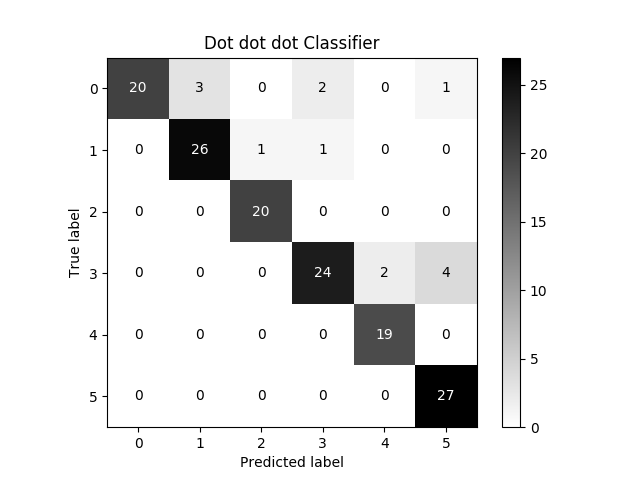

Text(0.5, 1.0, 'Dot dot dot Classifier')

In [26]:
%matplotlib notebook
labels = ["almadaNegreiros", "ecaDeQueiros", "joseSaramago",
          "camiloCasteloBranco", "joseRodriguesSantos", "luisaMarquesSilva"]
metrics.plot_confusion_matrix(dot_clf, X_test, y_test, cmap='gray_r')
plt.title("Dot dot dot Classifier")